In [4]:
import json
import os
from os import listdir
from os.path import isfile, join
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

import tabulate
import numpy as np
import math

from itertools import cycle, islice


In [5]:

fig_width = 8
fig_height = 5

params = {
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
#    'text.usetex': True,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
    'lines.linewidth': 2
}

matplotlib.rcParams.update(params)

In [9]:
data_dir = 'parallel_data_Nov'
out_dir = 'parallel_plots'


appname = 'LUBM'
data_size_dir = 'LUBM'
collections = ['schemex', 'attribute', 'type']
suffix = ''
hide_legend = False

appname = 'BSBM'
data_size_dir = 'BSBM'
collections = ['attribute']#, 'type', 'schemex'] #, 
parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
#parallizations = ['parallel_16', 'parallel_8', 'parallel_4', 'parallel_2', 'parallel_1']

suffix = '-test-1'
hide_legend = False
# BSBM_attribute-parallel_1-test-1-performance.csv'

# BSBM-attribute-parallel_1-test-1-performance.csv

appname = 'DyLDO-core'
data_size_dir = 'DyLDO-core'
collections =['attribute']
#parallizations = ['parallel_1']

suffix = '-test-2'
#hide_legend = True


#appname = 'dyldo_y2019_full'
#data_size_dir = 'DyLDO-ext'
#collections =['schemex', 'attribute', 'type']
#suffix = ''
#hide_legend = True


ticks = 5.0
interpolate = True

In [10]:
iterations = 0



performance_frame = pd.DataFrame() 
for collection in collections:
#    new_zero_incr = 0
#    new_zero_batch = 0
    for parallelization in parallizations:
        with open(os.path.join(data_dir, appname + '-'+collection+'-'+parallelization+suffix+'-performance.csv'), 'r') as f:
            df = pd.read_csv(f, sep=',')
            iterations = max(iterations, len(df['Iteration']))
            df = df.set_index('Iteration')
#            if parallelization == 'parallel_1':
#                new_zero_incr = df['Incremental Duration']
#                new_zero_batch = df['Batch Duration']
#                performance_frame[collection+'-'+parallelization+'-Inc'] = 0
#                performance_frame[collection+'-'+parallelization+'-Batch'] = 0

              
            performance_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
            performance_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']

                
    
    

#performance_frame.columns = ['SchemEX:Incr', 'SchemEX:Batch', 
#             'AttrColl:Incr', 'AttrColl:Batch',
#             'TypeColl:Incr', 'TypeColl:Batch']
 
convert = lambda x: x / 1000 / 60
performance_frame = performance_frame.applymap(convert)  
display(performance_frame.head())

if appname == 'dyldo_y2019_core' or appname == 'DyLDO-core':
    if interpolate:
        performance_frame = performance_frame.drop(performance_frame.index[[21,22]])
    else:
        performance_frame.loc[21:22,'SchemEX:Incr':'TypeColl:Batch']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    display(performance_frame)
    
if appname == 'dyldo_y2019_full':
    performance_frame = performance_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    
# style = ['--','-','--','-','--','-'], color=['darkslateblue', 'darkslateblue',
#                    'forestgreen', 'forestgreen', 'indianred', 'indianred']    
ax = performance_frame.plot(logy=False)
ax.set_xlabel("GDB version")
ax.set_ylabel("Minutes")
#ax.yaxis.set_label_coords(-0.075,.9)
plt.xticks(np.arange(0, iterations, ticks))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), shadow=True, ncol=2)

if hide_legend:
    ax.get_legend().remove()

plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-performance.pdf', bbox_inches = 'tight')
    


FileNotFoundError: [Errno 2] No such file or directory: 'parallel_data_Nov/DyLDO-core-attribute-parallel_4-test-2-performance.csv'

In [11]:
#display(performance_frame)
box = dict(facecolor='white', pad=5, alpha=0.2)


for collection in collections:
    values_incr = []
    values_batch = []
    for parallelization in parallizations:
        values_incr.append(np.array(performance_frame[collection+'-'+parallelization+'-Inc']))
        values_batch.append(np.array(performance_frame[collection+'-'+parallelization+'-Batch']))
        
    ## TODO parameterize
    X = [1]#,2]#,4,8,16]
    Y = np.arange(0, 50, 1) # 41
    X, Y = np.meshgrid(X, Y)
    Z = np.transpose(np.array(values_incr))


    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    #     surf = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
    #cmap=cm.coolwarm,
                           
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    #ax.set_zlim(-1.01, 1.01)
    #ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(appname + ' '+collection + ' Incr')
    plt.xticks([1,2])#,4,8,16])
    #plt.yticks(np.arange(0, iterations, ticks))
    ax.view_init(30, 25)
    
    ax.set_xlabel("Cores", labelpad=10, bbox=box)
    ax.set_ylabel("GDB version", labelpad=10, bbox=box)
    ax.set_zlabel("Minutes", labelpad=15, bbox=box)

    plt.savefig(out_dir + '/' + appname + '-'+collection + '-Incr' + '-parallel.pdf',  bbox_inches = 'tight')
    plt.show()
    ### batch
    Z = np.transpose(np.array(values_batch))

    fig = plt.figure()
    ax = Axes3D(fig)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    #ax.set_zlim(-1.01, 1.01)cmap=cm.coolwarm,
    #ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(appname + ' '+collection + ' Batch')
    plt.xticks([1,2])#,4,8,16])
    #plt.yticks(np.arange(0, iterations, ticks))
    
    ax.view_init(30, 25)
    
    ax.set_xlabel("Cores", labelpad=10, bbox=box)
    ax.set_ylabel("GDB version", labelpad=10, bbox=box)
    ax.set_zlabel("Minutes", labelpad=15, bbox=box)

    plt.savefig(out_dir + '/' + appname + '-'+collection + '-Batch' + '-parallel.pdf',  bbox_inches = 'tight')
    plt.show()
#     for angle in range(0, 360):
#         ax.view_init(30, angle)
#         plt.draw()
#         plt.pause(.001)


KeyError: 'attribute-parallel_4-Inc'

In [7]:
import numpy as np
import matplotlib.pyplot as plt




In [161]:
size_frame = pd.DataFrame()
for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()
        
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')

        if '|V|' not in size_frame:
            size_frame['|V|'] = df['Imprint links']
            
        size_frame[collection+':|V_vs|'] = df['Schema Elements (SE)']
        size_frame[collection+':|E_vs|'] = df['Schema Relations (SR)']


        
size_frame = size_frame.join(edgeframe,how='left')
display(size_frame.head())


,|V|,schemex:|V_vs|,schemex:|E_vs|,attribute:|V_vs|,attribute:|E_vs|,type:|V_vs|,type:|E_vs|,0
Iteration,,,,,,,,
0,7271943,243423,1303004,50208.0,706205.0,42300.0,0.0,82221979
1,7509702,249691,1413856,54281.0,781832.0,39785.0,0.0,82245640
2,7064987,240266,1333850,52570.0,744073.0,39088.0,0.0,82381421
3,10592783,232566,1405716,56388.0,790516.0,31781.0,0.0,106491385
4,10440827,225972,1370282,55389.0,785474.0,31194.0,0.0,105755426


In [162]:
display(size_frame['|V|'].min())
display(size_frame['|V|'].max())
display(size_frame['|V|'].mean())
display(size_frame['|V|'].std())

6382958

10718848

9097698.909090908

1663543.6874221521

drop the beat


,|V|,SchemEX:|V_vs|,SchemEX:|E_vs|,AttrColl:|V_vs|,AttrColl:|E_vs|,TypeColl:|V_vs|,TypeColl:|E_vs|,|E|
Iteration,,,,,,,,
0,7271943,243423,1303004,50208.0,706205.0,42300.0,0.0,82221979
1,7509702,249691,1413856,54281.0,781832.0,39785.0,0.0,82245640
2,7064987,240266,1333850,52570.0,744073.0,39088.0,0.0,82381421
3,10592783,232566,1405716,56388.0,790516.0,31781.0,0.0,106491385
4,10440827,225972,1370282,55389.0,785474.0,31194.0,0.0,105755426


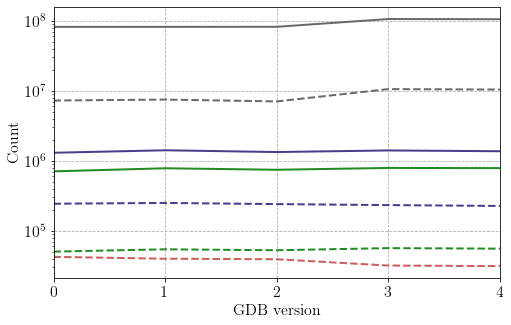

In [163]:
size_frame.columns = ['|V|', 'SchemEX:|V_vs|','SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|E|']

if appname == 'dyldo_y2019_core':
    if interpolate:
        size_frame = size_frame.drop(size_frame.index[[21,22]])
    else:
        size_frame.loc[21:22,'|V|':'|E|']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
   

if appname == 'dyldo_y2019_full':
    size_frame = size_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    
  
display(size_frame)

sorted_frame = size_frame[['SchemEX:|V_vs|', 'SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|V|', '|E|']]

sorted_frame.columns=['SchemEX:$|V_{vs}|$', 'SchemEX:$|E_{vs}|$' 
                    , 'AttrColl:$|V_{vs}|$', 'AttrColl:$|E_{vs}|$'
                    , 'TypeColl:$|V_{vs}|$', 'TypeColl:$|E_{vs}|$', '$|V|$', '$|E|$']

ax = sorted_frame.plot(logy=True, style = ['--','-','--','-','--','-','--','-'], 
                       color=['darkslateblue', 'darkslateblue',
                             'forestgreen','forestgreen',
                             'indianred','indianred', 'dimgray', 'dimgray'])#,yticks=([math.exp(w) for w in np.arange(1, 10, 2)]))
#ax.set_ylim([2500, 80000])color=['dimgray', 'darkslateblue']
#plt.yticks(np.arange(0, iterations, 5.0))
#plt.
plt.xticks(np.arange(0, iterations, ticks))
ax.set_xlabel("GDB version")
ax.set_ylabel("Count")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)
if hide_legend:
    ax.get_legend().remove()
    
plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-sizes.pdf',  bbox_inches = 'tight')

Index(['NewlyObservedSchema (SE_new)', 'DeletedSchemaStructures (SE_del)',
       'ChangedSchemaStructures (SE_mod)', 'InstanceNotChanged (PE_mod)'],
      dtype='object')
Index(['NewlyObservedSchema (SE_new)', 'DeletedSchemaStructures (SE_del)',
       'ChangedSchemaStructures (SE_mod)', 'InstanceNotChanged (PE_mod)'],
      dtype='object')
Index(['NewlyObservedSchema (SE_new)', 'DeletedSchemaStructures (SE_del)',
       'ChangedSchemaStructures (SE_mod)', 'InstanceNotChanged (PE_mod)'],
      dtype='object')


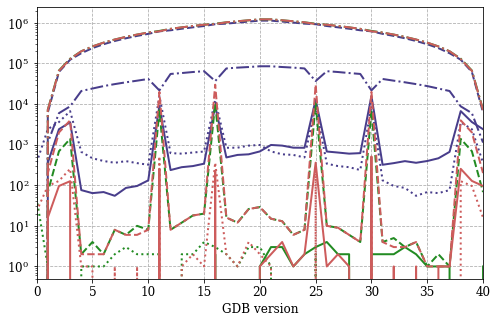

In [9]:
frames = [None, None, None]
i = 0
iterations = 0
for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()

        #del df['NewlyObservedSchema (SE_new)']
        #del df['DeletedSchemaStructures (SE_del)']

        
        del df['TotalNumberOfNewInstances'] 
        del df['InstanceAddedWithKnownSchema (PE_add)']
        del df['InstancesDeleted (PE_del)']
        del df['ChangedSchemaStructuresBecauseOfNeighbor'] 
        del df['PayloadEntriesAdded'] 
        del df['PayloadEntriesRemoved'] 
        del df['InstanceToSchemaLinksAdded'] 
        del df['InstanceToSchemaLinksRemoved'] 

        del df['TotalNumberOfChangedPayloadElements (real PE_mod)']
        
        del df['TotalNumberOfSchemaElementsWritten']
        del df['TotalNumberOfSchemaElementsDeleted']
        #del df['InstanceNotChanged (PE_mod)']
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')
        print(df.columns)
        df.columns = [collection+'ADD', collection+'DEL', collection+'MOD', collection+'unchanged']    #'Modified pe(v)'
        
        #df.columns = [collection+'MOD-ELEM', collection+'Unchanged v', collection+'ADD-ELEM', collection+'DEL-ELEM']    #'Modified pe(v)'
        #df = df[[collection+'ADD-ELEM', collection+'DEL-ELEM', collection+'MOD-ELEM',collection+'Unchanged v']] #'Modified pe(v)'
        frames[i] = df
        i = i + 1
        
df = pd.concat(frames, sort=False)


df.columns = ['SchemEX:ADD', 'SchemEX:DEL', 'SchemEX:MOD','SchemEX:PAY',
             'AttrColl:ADD', 'AttrColl:DEL', 'AttrColl:MOD','AttrColl:PAY',
             'TypeColl:ADD', 'TypeColl:DEL', 'TypeColl:MOD','TypeColl:PAY']
ax = df.plot(logy=True, style = [':','-','--','-.',':','-','--','-.',':','-','--','-.'], 
             color=['darkslateblue', 'darkslateblue', 'darkslateblue', 'darkslateblue', 
                    'forestgreen', 'forestgreen', 'forestgreen','forestgreen',
                   'indianred', 'indianred', 'indianred','indianred'])
#ax.set_ylabel("Quantity")
#ax.yaxis.set_label_coords(-0.015,1.0)
plt.xticks(np.arange(0, iterations, 5.0))
ax.set_xlabel("GDB version")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)

if hide_legend:
    ax.get_legend().remove()

plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-changes.png', bbox_inches = 'tight')